In [1]:
# Import modules and dependencies

import os
from os import listdir
from os.path import isdir, join
import pathlib

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


import akida
from akida import FullyConnected
from akida import evaluate_sparsity
import cnn2snn
from cnn2snn import check_model_compatibility
from cnn2snn import quantize
from cnn2snn import quantize_layer
from cnn2snn import convert

import librosa
from librosa import display

from math import ceil


In [2]:
# If needed, set seed for experiment reproducibility

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Set data directory

data_dir = pathlib.Path('data/Modded_Google_Edge')
edge_dir = pathlib.Path('data/Edge_Categories')

In [4]:
# Check commands

targets = np.array(tf.io.gfile.listdir(str(data_dir)))

targets = targets[targets != 'README.md']

targets = targets[targets != 'follow']
targets = targets[targets != 'forward']
targets = targets[targets != 'backward']

targets_edge = np.array(tf.io.gfile.listdir(str(edge_dir)))

targets = np.append(targets, targets_edge)

print('Known and unknown commands:', targets)
print('Newly added commands for edge learning:', targets_edge)

Known and unknown commands: ['off' 'up' 'down' 'on' 'stop' 'yes' 'right' 'unknown' 'left' 'go' 'no'
 'silence' 'forward' 'follow' 'backward']
Newly added commands for edge learning: ['forward' 'follow' 'backward']


In [5]:
# Loading preprocessed Data

feature_sets_path = '/home/sebastian/Schreibtisch/Masterarbeit/Audio/'
feature_sets_filename = 'stored_files_targets_edge.npz'


In [6]:
# Load feature sets

feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val']


In [8]:
# Assign feature sets

x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']

In [9]:
# Check label distribution of training set

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 45,
 1.0: 45,
 2.0: 45,
 3.0: 45,
 4.0: 45,
 5.0: 45,
 6.0: 45,
 7.0: 72,
 8.0: 45,
 9.0: 45,
 10.0: 45,
 11.0: 72,
 12.0: 40,
 13.0: 40,
 14.0: 40}

In [10]:
# Check label distribution of validation set

unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0.0: 5,
 1.0: 5,
 2.0: 5,
 3.0: 5,
 4.0: 5,
 5.0: 5,
 6.0: 5,
 7.0: 8,
 8.0: 5,
 9.0: 5,
 10.0: 5,
 11.0: 8,
 12.0: 6,
 13.0: 7,
 14.0: 6}

In [13]:
# Look at tensor dimensions

print(x_train.shape)
print(x_val.shape)


(714, 40, 101)
(85, 40, 101)


In [14]:
# Local Cepstral Mean and Variance Normalization

x_train = librosa.util.normalize(x_train, norm=np.inf, axis=2, threshold=None, fill=None)
x_val = librosa.util.normalize(x_val, norm=np.inf, axis=2, threshold=None, fill=None)


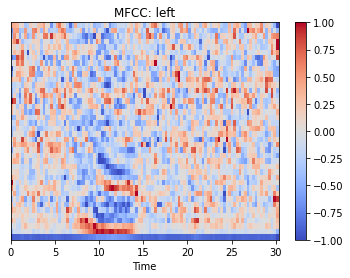

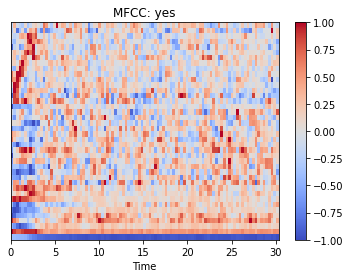

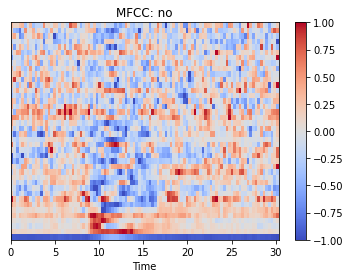

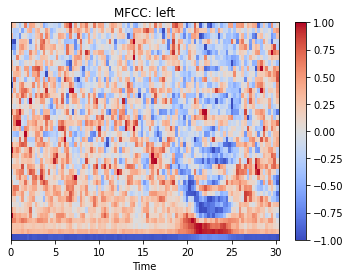

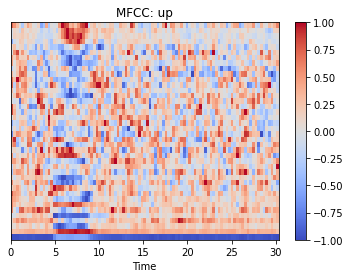

In [15]:
# Print example MFCCs after Normalization

counter = 0

while counter < 5:

    spectrogram = x_train[counter]
    #spectrogram= np.swapaxes(spectrogram, 0 ,1)
    label = targets[int(y_train[counter])]

    fig, ax = plt.subplots()

    img = librosa.display.specshow(spectrogram, sr = 16000, hop_length=16000*0.30 , x_axis='time', ax=ax)

    fig.colorbar(img, ax=ax)

    ax.set(title='MFCC: ' + label)
    
    counter+=1

In [16]:
# Conversion of the normalized data

x_train = (x_train * 127.5 + 127.5).astype('uint8')
x_val = (x_val * 127.5 + 127.5).astype('uint8')


In [17]:
# Save normalized

feature_sets_file = 'final_stored_files_targets_int_normalized_edge.npz'
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val)